In [74]:
import re
from matplotlib import pyplot as plt
import networkx as nx

## Extracting pages

In [53]:
def selectFirstVersionForEachFord(paragraph: str) -> str:
    return re.sub(r'\((.*?)\|.*?\)', r'\1', paragraph)

def extractCodexPages(file) -> list[str]:
    paragraphs = []
    current_paragraph = ''
    
    for line in file:
        if line.strip().startswith("#") or len(line) < 2:
            continue

        last_character = line[-2]

        if last_character in ['-', '=']:
            current_paragraph += line[:-2]
        else:
            current_paragraph += line[:-1]

        if last_character == '=':
            paragraphs.append(selectFirstVersionForEachFord(current_paragraph.strip()))
            current_paragraph = ''

    return paragraphs

def extractWordsFromParagraphAndLower(paragraph: str) -> list[str]:
    return re.split(r'[\s,\.\[\]\{\}:;"]', paragraph.lower().replace('-', '').replace('_', ''))


# ------------------------------------- - ------------------------------------ #

def readCodex(path: str) -> list[str]:
    with open(path, 'r') as f:
        return list(map(extractWordsFromParagraphAndLower, extractCodexPages(f)))


In [54]:
for p in readCodex('FSG.txt'):
    print(p)

['fgag2', 'gdae', 'ar', 'gham', 'soe', 'sorg', '0d0rc2', 'gdor', 'soe8g2org', 'dzar', 'org', 'dair', 'tham', 'sor', 'ar', 'hzar', 'hzar', '8ala2gaiir', 'scdg', 'or', 'gdam', 'so8', 'hzoarg', 'hzc2', '8aram', '2g0om', 'ohccg', 'ohcar', 'roeohg', 'hzaar', '8am', 'odam', 'or', 'odal2airg', 'tcar', 'hzam', 'pzar', 'fzam']
['g8araisg']
['o8ar', 'sg', 'soe', 'pzog', 'og8ar', 's', '2', 'fzoam', 'so8arggscg', 'so8g', 'odto', 'g', 'ohtoe', 'tohzg', 'o2tg', '8an', 'tor', 'do28am', 'sor', 'fzoe', 'so8g']
['8an', '02', 'hco8g']
['g8an', 'pzc2am', 'oe2', 'pzcg', 'ghan', 'sosg', 'pzo8aec2odso', 'dsog', 'ohairn', 'ohcoe', 'odal', 'so8an', '2dzcg', '8amsog', 'dzcg', 'do8am', 'pzg', 'pz08aiie2', 'hzcg', 'sc', 'oe8an', '88an', 'om', 'toe', 'o8am', 'to8an', 't8g', 'odon', '80r', 'hzg', 'do88am', 'sdzcg', 'dzor', 'tor', 'scg', 'doe', 'toe', 'toe', 'dor', 'toeso', 'toe', 'so8al', 'dsg', 'dtg', '8or', 'to8am', 'so', 'docakgto', 'htcg', 'tcdan', 'sco', 'psoe', '8g8g8', 'hzg', '8aihzggho', 'soe', 'sc', 'do8sc

## Counting N-Grams

In [55]:
def countNGrams(text: list[str], n: int) -> dict[str, int]:
    ngrams = {}

    for paragraph in text:
        for i in range(len(paragraph) - n + 1):
            ngram = ' '.join(paragraph[i:i+n])
            if ngram not in ngrams:
                ngrams[ngram] = 0
            ngrams[ngram] += 1

    return ngrams

In [56]:
def getSortedNGramsAndCalculateScores(ngrams: dict[str, int]) -> list[tuple[str, int]]:
    return list(map(lambda pair: (pair[1][0], pair[1][1], pair[0] / pair[1][1]), enumerate(sorted(ngrams.items(), key=lambda x: x[1], reverse=True))))

In [83]:
def filterGraphByRequiringMinimalDegree(graph: dict[str, set[str]], minimal_degree: int) -> dict[str, set[str]]:
    return {k: v for k, v in graph.items() if len(v) >= minimal_degree}

def getWordsGraphs(text: list[str]) -> (dict[str, set[str]], dict[str, set[str]]):
    graph_forward = {}
    graph_backward = {}

    for paragraph in text:
        for i in range(len(paragraph) - 1):
            word = paragraph[i]
            next_word = paragraph[i+1]

            if word not in graph_forward:
                graph_forward[word] = set()
            if next_word not in graph_backward:
                graph_backward[next_word] = set()
            
            graph_forward[word].add(next_word)
            graph_backward[next_word].add(word)

    return (graph_forward, graph_backward)

def getFilteredWordsGraph(text: list[str], minimal_degree: int) -> dict[str, set[str]]:
    graph_forward, graph_backward = getWordsGraphs(text)
    filtered_graph_forward = filterGraphByRequiringMinimalDegree(graph_forward, minimal_degree)
    filtered_graph_backward = filterGraphByRequiringMinimalDegree(graph_backward, minimal_degree)

    return {k: v for k, v in filtered_graph_forward.items() if k in filtered_graph_backward}

def drawBipartialGraph(graph: dict[str, set[str]], title: str):
    plt.figure(figsize=(30, 30))
    plt.title(title)
    plt.axis('off')

    G = nx.DiGraph()

    positions_A = {}
    positions_B = {}
    for i, word in enumerate(graph):
        positions_A[word] = (0, i)
        positions_B[word] = (1, i)
        for next_word in graph[word]:
            G.add_edge(word, next_word)

    nx.draw(G)

    plt.show()

In [78]:
print(list(sorted(countNGrams(readCodex('FSG.txt'), 3).items(), key=lambda x: x[1], reverse=True)))

[('scg 4odam tc8g', 4), ('tcg 4oe tc8g', 4), ('toe toe 8am', 3), ('4odc8g 4odc8g 4odc8g', 3), ('4oe tc8g 4odam', 3), ('sc8g 4odam scg', 3), ('oe sc8g 4odc8g', 3), ('sc8g 4odc8g 4odcc8g', 3), ('oe sc8g 4odccg', 3), ('tc8g 4odccg 4odccg', 3), ('toe tg tam', 2), ('toe toe toe', 2), ('hzor toe tor', 2), ('tam thzg hzo', 2), ('8am 4ohtg 4ohor', 2), ('tor toe 8am', 2), ('toe 8am tdam', 2), ('odc8g odc8g 4odc8g', 2), ('8am 8am o8g', 2), ('8ar ar ae', 2), ('tor tcdg toe', 2), ('or am to8g', 2), ('oe 2 am', 2), ('oham ohar tc8g', 2), ('sc8g 4odan 8ar', 2), ('sc8g 4odar sc8g', 2), ('4odam oe tc8g', 2), ('oe tc8g 4oe', 2), ('tc8g 4oe tc8g', 2), ('scc8g 4odc8g tc8g', 2), ('4odc8g tc8g tc8g', 2), ('8air tcg 4odam', 2), ('8ae t8g 8ae', 2), ('4odc8g 4odcc8g 4odc8g', 2), ('4oe sc8g oe', 2), ('sccg or or', 2), ('4oham tc8g 4odam', 2), ('tc8g 4odam tc8g', 2), ('tc8g 4odam sc8g', 2), ('sc8g 4odcc8g 4odc8g', 2), ('sc8g tc8g 4oe', 2), ('4odcc8g 4odccg ram', 2), ('sc8g 4odae tc8g', 2), ('4odae tc8g 4odc8g',

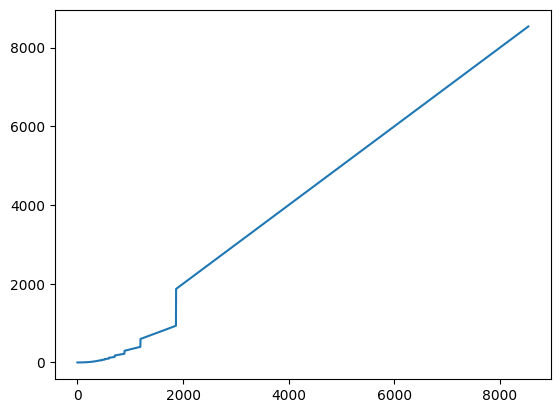

In [79]:
getSortedNGramsAndCalculateScores(countNGrams(readCodex('FSG.txt'), 1))

plt.plot(list(map(lambda x: x[2], getSortedNGramsAndCalculateScores(countNGrams(readCodex('FSG.txt'), 1)))))

KeyboardInterrupt: 

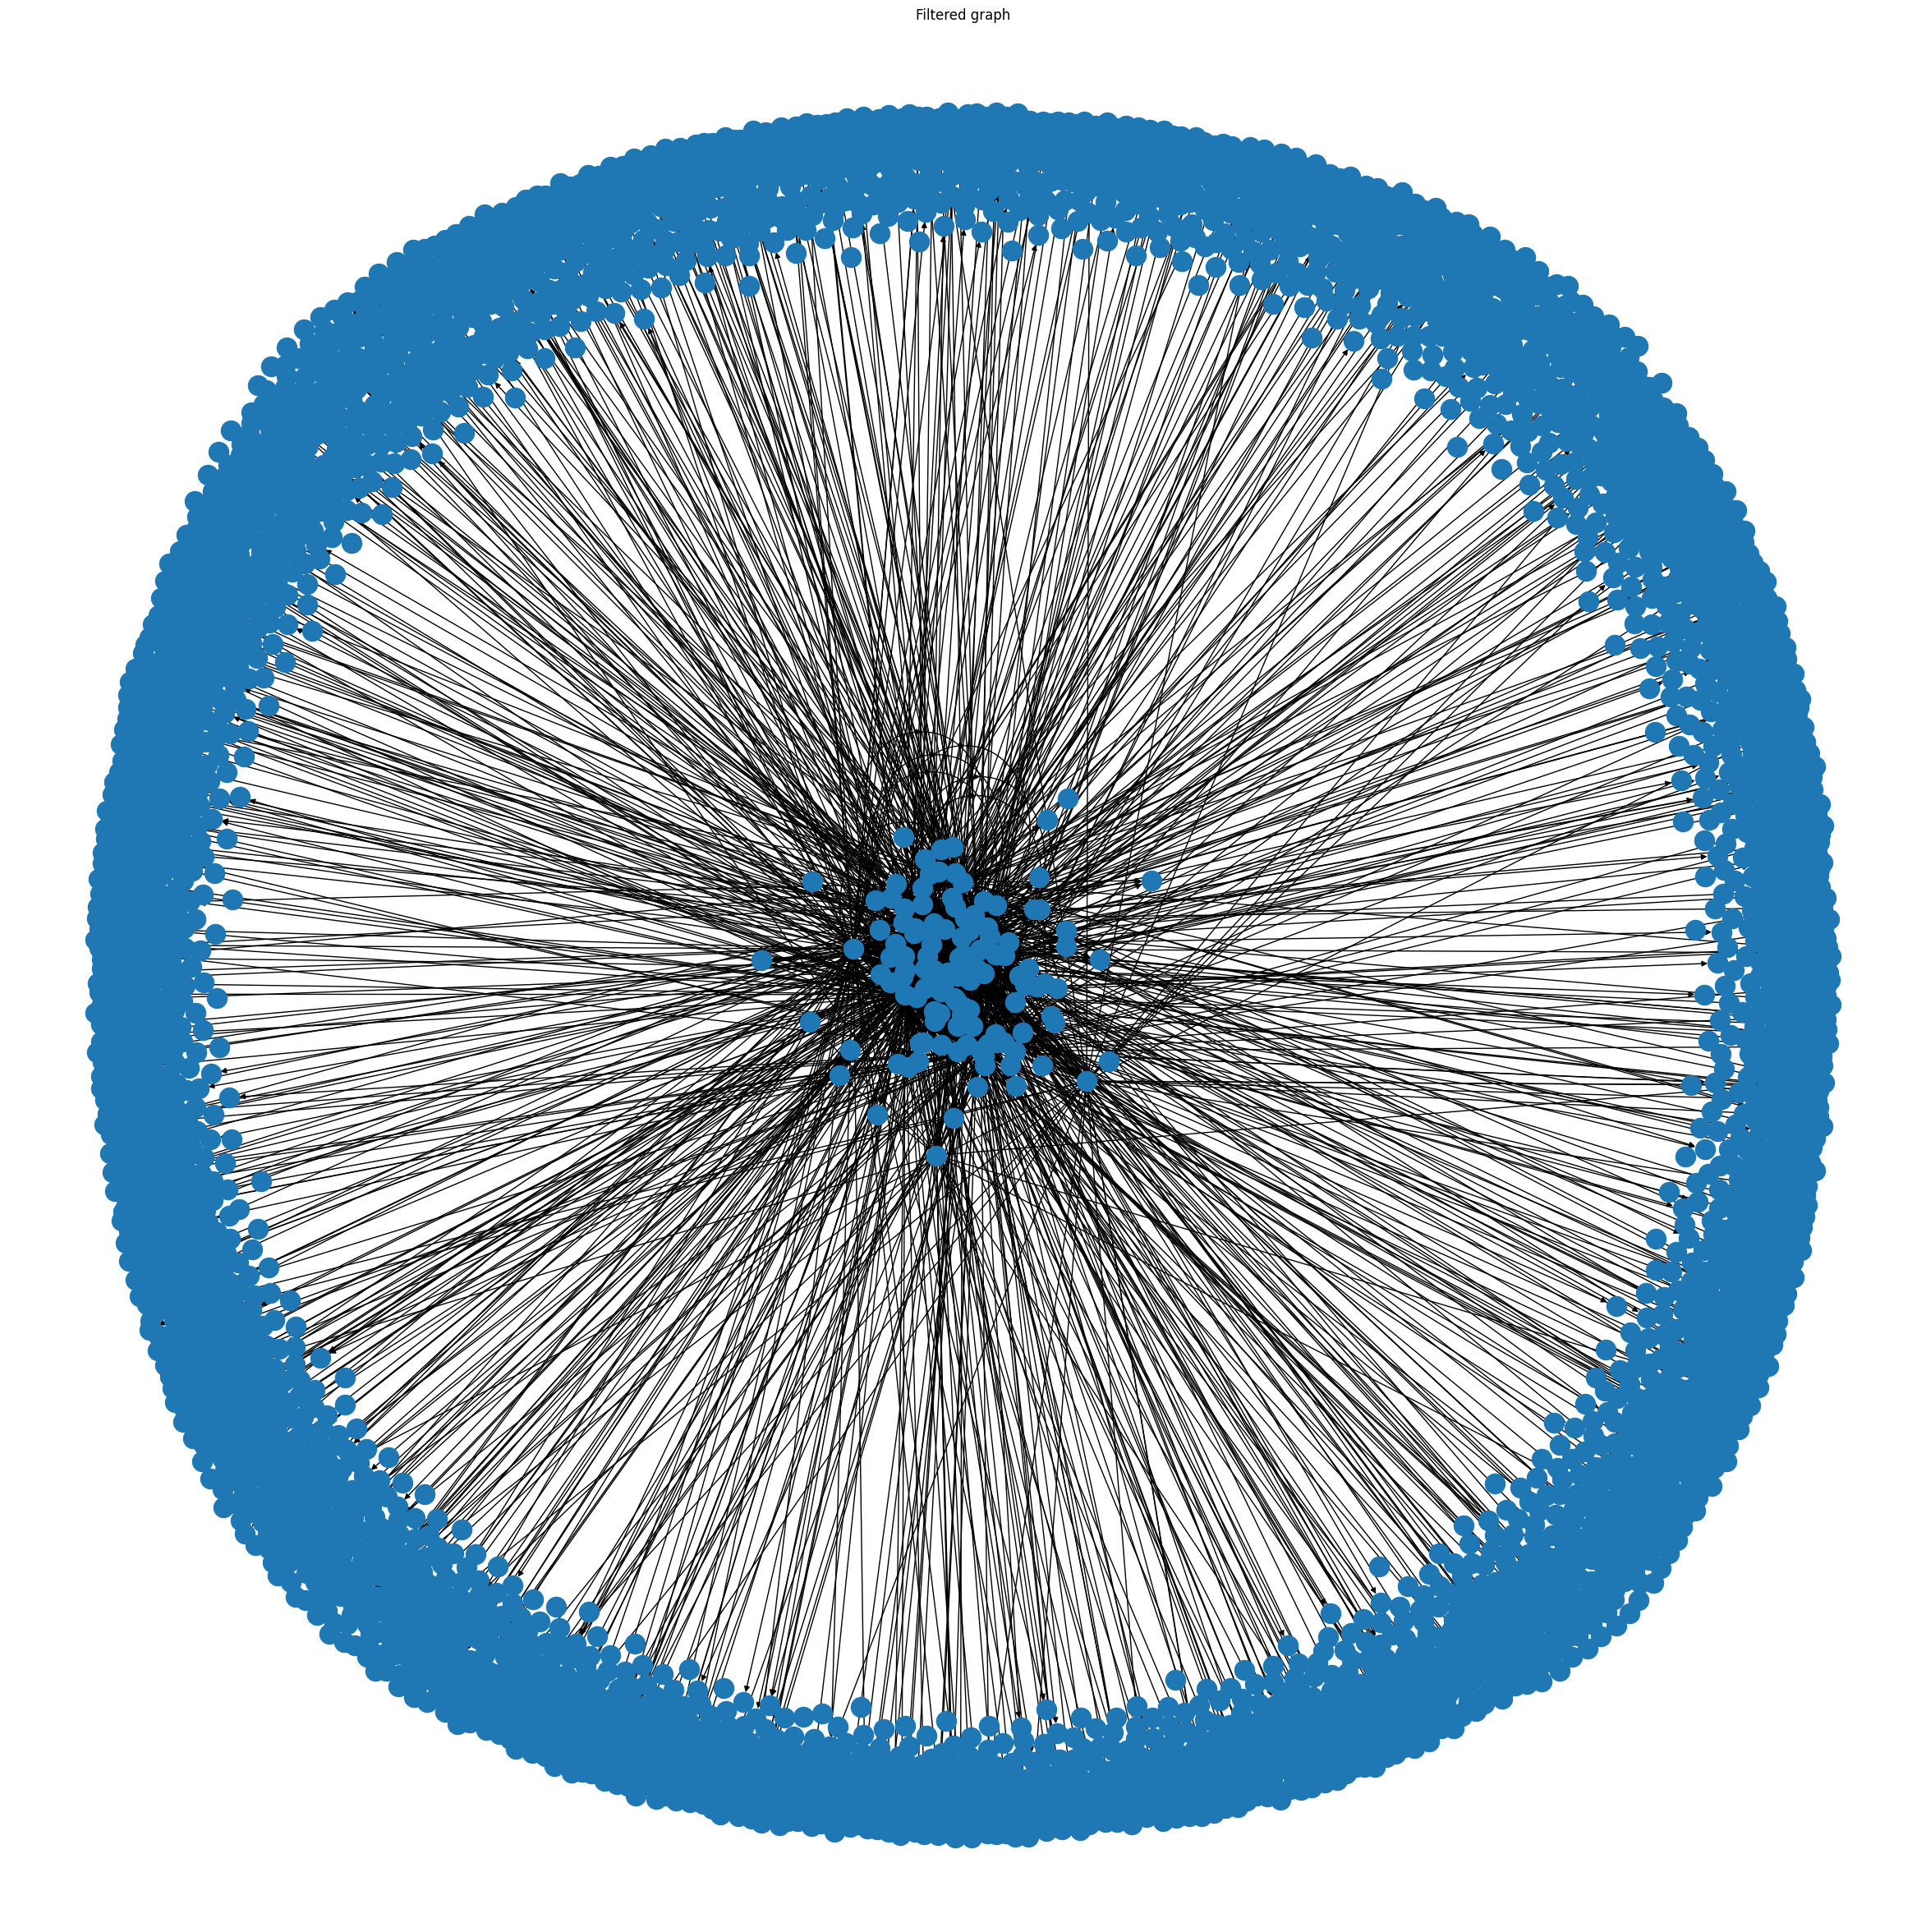

In [92]:
drawBipartialGraph(getFilteredWordsGraph(readCodex('FSG.txt'), 30), 'Filtered graph')